In [1]:
!pip install segmentation-models

In [2]:
!pip install patchify tifffile 

In [4]:
# from unet import simple_unet_model
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

import cv2

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

import random

2025-05-10 18:43:08.968164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746880988.985299   22469 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746880988.990579   22469 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746880989.004739   22469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746880989.004757   22469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746880989.004758   22469 computation_placer.cc:177] computation placer alr

Segmentation Models: using `tf.keras` framework.


In [24]:
seed=24

input_shape = (256, 256, 3)

IMG_HEIGHT = input_shape[1]
IMG_WIDTH = input_shape[0]
IMG_CHANNELS = input_shape[2]

mask_path="/home/ragibabdi127/polyp_project/data/Polyp data original plus processed/blue_inverted/masks"
image_path="/home/ragibabdi127/polyp_project/data/Polyp data original plus processed/blue_inverted/images"
processed=1

BACKBONE='resnet34'
model_save_location='data/Polyp data original plus processed/blue_inverted_combined/model2-unet_resnet18_dice_loss.weights.h5'
num_epochs=100

In [6]:
# Define the desired shape
def img_read(path):
    desired_shape = (IMG_WIDTH, IMG_HEIGHT)

    # Load the image
    image = cv2.imread(path,)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # Resize the image to the desired shape
    desired_size = (IMG_WIDTH, IMG_HEIGHT)



    # Convert the image to a numpy array for further processing
    return cv2.resize(img,desired_shape, interpolation=cv2.INTER_AREA)
def msk_read(path):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    desired_size = (IMG_WIDTH, IMG_HEIGHT)
 
    resized_image = cv2.resize(img, desired_size, interpolation=cv2.INTER_AREA)

    # Convert the image to a numpy array for further processing
    return resized_image

In [7]:
large_image_stack = []
large_mask_stack = []
mask_file_names=os.listdir(mask_path)
X=[]
y=[]

for i in mask_file_names:
    try:
        p=os.path.join(image_path,i)
        X.append(os.path.join(image_path,("Processed_"+i)).replace(".png", ".jpg") if processed else os.path.join(image_path,i).replace(".png", ".jpg"))
        y.append(os.path.join(mask_path,i))
        
        
    except:
        print(f'{i} does not exist in image')



for file_path in X:   
    #print('0')
    signal = img_read(file_path)/255.
    
    large_image_stack.append(signal)


for file_path in y:   
    #print('1')
    signal = msk_read(file_path)/255.
    large_mask_stack.append(signal)
   


In [8]:
large_image_stack=np.array(large_image_stack)
large_mask_stack=np.array(large_mask_stack)
large_mask_stack=np.expand_dims(large_mask_stack, -1)

In [9]:
large_image_stack.shape, large_mask_stack.shape

((1289, 256, 256, 3), (1289, 256, 256, 1))

In [10]:
preprocess_input1=sm.get_preprocessing(BACKBONE)

In [11]:
images1=preprocess_input1(large_image_stack)

In [12]:
X_train, X_test, y_train, y_test=train_test_split(images1,large_mask_stack,random_state=42, test_size=0.15)

In [13]:
X_train_g=X_train #[:,:,:,1]
X_test_g=X_test

In [14]:
X_train_g.shape,y_train.shape,X_test_g.shape,y_test.shape

((1095, 256, 256, 3),
 (1095, 256, 256, 1),
 (194, 256, 256, 3),
 (194, 256, 256, 1))

In [15]:
image_data_generator=ImageDataGenerator()
image_data_generator.fit(X_train,augment=False,seed=seed)

image_generator=image_data_generator.flow(X_train_g,seed=seed)
valid_img_generator=image_data_generator.flow(X_test,seed=seed)

In [16]:
mask_data_generator=ImageDataGenerator()
mask_data_generator.fit(y_train,augment=False,seed=seed)

mask_generator=mask_data_generator.flow(y_train,seed=seed)
valid_mask_generator=mask_data_generator.flow(y_test,seed=seed)

In [17]:
def my_image_generator(image_generator, mask_generator):
    train_generator=zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        yield (img, mask)

In [18]:
my_generator=my_image_generator(image_generator, mask_generator)

validation_datagen=my_image_generator(valid_img_generator, valid_mask_generator)

In [19]:
model=sm.Unet(BACKBONE, encoder_weights="imagenet", input_shape=input_shape)
model.compile('Adam',loss=sm.losses.bce_dice_loss,metrics=[sm.metrics.iou_score,sm.losses.bce_jaccard_loss])
model.summary()

I0000 00:00:1746880997.757162   22469 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5837 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [25]:
callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
#     tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(model_save_location, verbose=1, save_best_only=True, save_weights_only=True)
]
history=model.fit(my_generator,validation_data=validation_datagen,steps_per_epoch=50,validation_steps=50, epochs=num_epochs,callbacks=callbacks, batch_size=8)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - binary_crossentropy_plus_jaccard_loss: 0.0366 - iou_score: 0.9712 - loss: 0.0224
Epoch 1: val_loss improved from inf to 1.10709, saving model to data/Polyp data original plus processed/blue_inverted_combined/model2-unet_resnet18_dice_loss.weights.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - binary_crossentropy_plus_jaccard_loss: 0.0366 - iou_score: 0.9712 - loss: 0.0224 - val_binary_crossentropy_plus_jaccard_loss: 1.2406 - val_iou_score: 0.4567 - val_loss: 1.1071
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - binary_crossentropy_plus_jaccard_loss: 0.0376 - iou_score: 0.9700 - loss: 0.0228
Epoch 2: val_loss improved from 1.10709 to 1.09101, saving model to data/Polyp data original plus processed/blue_inverted_combined/model2-unet_resnet18_dice_loss.weights.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - binary_crossentropy_plus_jaccard_loss: 0.0377 - iou_score: 0.9700 - loss: 0.0228 - val_binary_crossentropy_plus_jaccard_loss: 1.2274 - val_iou_score: 0.4594 - val_loss: 1.0910
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - binary_crossentropy_plus_jaccard_loss: 0.0419 - iou_score: 0.9663 - loss: 0.0250
Epoch 3: val_loss did not improve from 1.09101
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - binary_crossentropy_plus_jaccard_loss: 0.0419 - iou_score: 0.9663 - loss: 0.0250 - val_binary_crossentropy_plus_jaccard_loss: 1.2437 - val_iou_score: 0.4669 - val_loss: 1.1256
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - binary_crossentropy_plus_jaccard_loss: 0.0375 - iou_score: 0.9699 - loss: 0.0226
Epoch 4: val_loss improved from 1.09101 to 1.04008, saving model to data/Polyp data original plus processed/blue_inverted_combined/model2-unet_resnet18_dice_loss.weights.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - binary_crossentropy_plus_jaccard_loss: 0.0375 - iou_score: 0.9699 - loss: 0.0226 - val_binary_crossentropy_plus_jaccard_loss: 1.1430 - val_iou_score: 0.4796 - val_loss: 1.0401
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - binary_crossentropy_plus_jaccard_loss: 0.0366 - iou_score: 0.9708 - loss: 0.0222
Epoch 5: val_loss did not improve from 1.04008
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - binary_crossentropy_plus_jaccard_loss: 0.0366 - iou_score: 0.9708 - loss: 0.0222 - val_binary_crossentropy_plus_jaccard_loss: 1.2219 - val_iou_score: 0.4550 - val_loss: 1.0975
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - binary_crossentropy_plus_jaccard_loss: 0.0366 - iou_score: 0.9706 - loss: 0.0222
Epoch 6: val_loss did not improve from 1.04008
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - binary_crossentropy_plus_jaccard_loss: 0.0366 - iou_score: 0.9706 - loss: 0.0222 - val_binary_crossentropy_plus_jaccard_loss: 1.2623 - val_iou_score: 

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - binary_crossentropy_plus_jaccard_loss: 0.2861 - iou_score: 0.7869 - loss: 0.1931 - val_binary_crossentropy_plus_jaccard_loss: 1.1649 - val_iou_score: 0.4085 - val_loss: 1.0155
Epoch 35/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - binary_crossentropy_plus_jaccard_loss: 0.1673 - iou_score: 0.8732 - loss: 0.1091
Epoch 35: val_loss improved from 1.01554 to 0.86301, saving model to data/Polyp data original plus processed/blue_inverted_combined/model2-unet_resnet18_dice_loss.weights.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - binary_crossentropy_plus_jaccard_loss: 0.1670 - iou_score: 0.8734 - loss: 0.1089 - val_binary_crossentropy_plus_jaccard_loss: 1.0424 - val_iou_score: 0.4278 - val_loss: 0.8630
Epoch 36/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - binary_crossentropy_plus_jaccard_loss: 0.1085 - iou_score: 0.9153 - loss: 0.0676
Epoch 36: val_loss did not improve from 0.86301
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - binary_crossentropy_plus_jaccard_loss: 0.1083 - iou_score: 0.9155 - loss: 0.0675 - val_binary_crossentropy_plus_jaccard_loss: 1.3157 - val_iou_score: 0.3185 - val_loss: 1.1720
Epoch 37/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - binary_crossentropy_plus_jaccard_loss: 0.0744 - iou_score: 0.9413 - loss: 0.0457
Epoch 37: val_loss did not improve from 0.86301
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - binary_crossentropy_plus_jaccard_loss: 0.0743 - iou_score: 0.9414 - loss: 0.0456 - val_binary_crossentropy_plus_jaccard_loss: 1.1201 - val_iou_sco

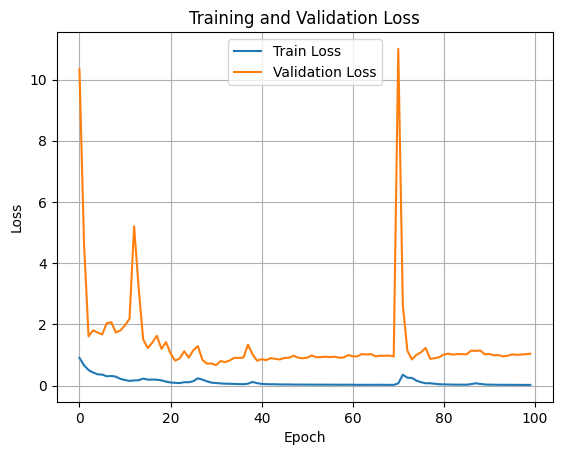

In [21]:
# Assuming 'history' is the result of model.fit()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
model=sm.Unet(BACKBONE, encoder_weights="imagenet", input_shape=input_shape)
model.load_weights(model_save_location)

In [28]:
y_pred=model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step


In [29]:
y_pred_thresh=y_pred>0.5
intersection=np.logical_and(y_test,y_pred_thresh)
union=np.logical_or(y_test,y_pred_thresh)
iou=np.sum(intersection)/np.sum(union)
iou

0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


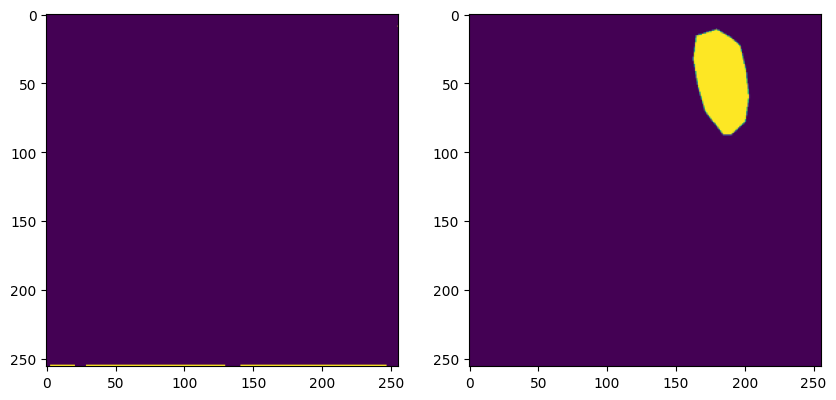

In [30]:
test_img_num=random.randint(0,len(X_test)-1)
test_img=X_test[test_img_num]
test_img_input=np.expand_dims(test_img,0)
gt=y_test[test_img_num]
yp=model.predict(test_img_input)

plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(yp[0,:,:,0]>.5)
plt.subplot(122)
plt.imshow(gt[:,:,0])


In [ ]:
yp.shape

In [ ]:
plt.imshow(yp[0,:,:,0])

In [ ]:
plt.imshow(gt[:,:,0])

In [ ]:
gt.shape